# Лабораторная работа №1

**Цель работы:** изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

**Задачи:**
 1. Освоить Jupyter Notebook 
 2. Выполнить загрузку аудио сигнала и построить огибающую(график) 
 3. Фильтрация(выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал. 
 4. Детектор сигнал/шум. Получить сигнал после детекитрования. 
 5. Эффект "Эхо". Получить сигнал после работы аудио-эффекта. 
 6. Бонусное задание: эффект "Distortion"(классический вариант). Получить сигнал после работы аудио-эффекта. 

## 1.  Загрузка аудио сигнала и построение огибающей.
Имеется сигнал $x(i), i=0,1,...,N - 1$. Хотим построить огибающую $y(j) = 0,1,...,n-1$ \
Пусть $m=[\frac{N}{n}]$ - число точек в интервале усреднения. $n = 400$. Тогда \
$y(i)=\frac{1}{m} \sum\limits_{k=mj}^{mj+m-1}|x(k)|$


C:\Users\cdcvh\AppData\Local\Temp/ipykernel_18448/2038822571.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('03-01-05-01-01-02-07_A7.wav')


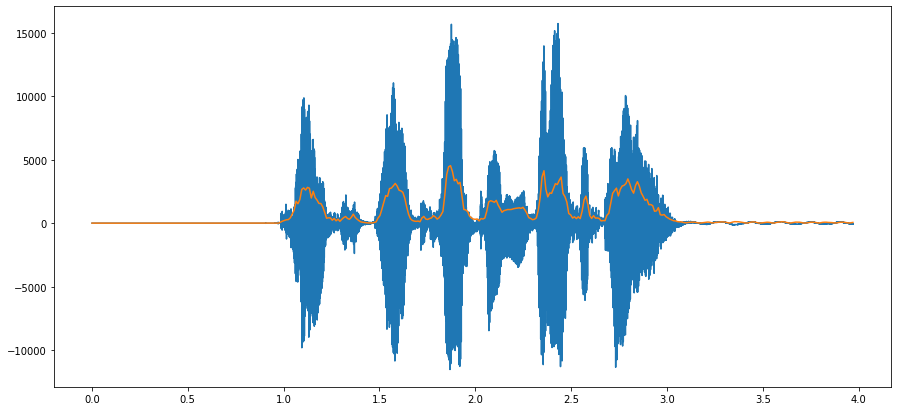

In [155]:
from scipy.io import wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import IPython

samplerate, data = wavfile.read('03-01-05-01-01-02-07_A7.wav')
time_ax = np.linspace(0,  data.shape[0] / samplerate, data.shape[0])
N = data.shape[0]
n = 400
m = int(N/n)
y = []
values = np.linspace(0, data.shape[0] / samplerate, n)
for j in range(0, n):
    temp  = 0
    for k in range(m*j, m*j+m):
        temp += abs(data[k])
    temp /= m
    y.append(temp)
    
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
ax.plot(time_ax, data)
ax.plot(values, y)

## 2. Фильтрация нижних частот
Пусть $F_d$ - частота дискретизации, частота среза - $F_s$, порядок фильтра - $m$. Тогда $wn=2\frac{F_s}{F_d}$ \
Были взяты следующие константы: \
$F_s$ = 3000 \
$m$ = 2

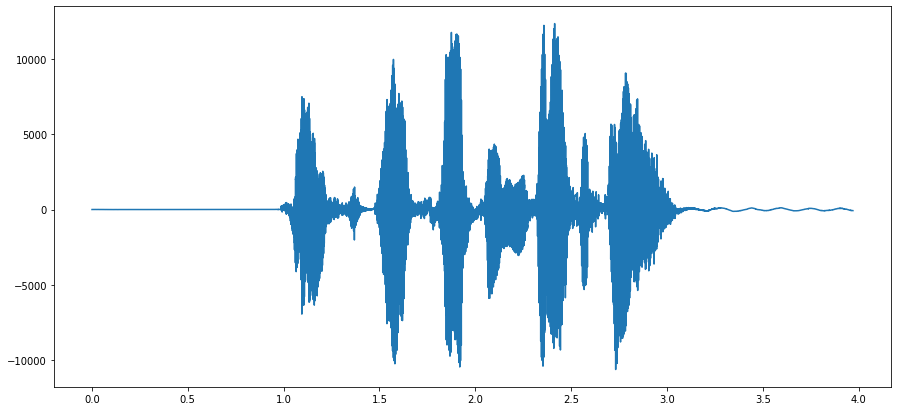

In [159]:
def lowpass(data, m):
    wn = 2 * 3000 / samplerate
    b, a = signal.butter(m, wn, 'lowpass')
    return signal.filtfilt(b, a, data)

new_data = lowpass(data, 2)
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
ax.plot(time, new_data)
IPython.display.Audio(new_data, rate=samplerate)


## 3. Детектор сигнал/шум
Определяем среднее сигнала по амплитуде (без учета знака): \
$mid = \frac{1}{N}\sum_{k=0}^{N-1}{|x(k)|}$ \
Определяем порог детектора - $Th = \alpha * mid$, где $0<\alpha<1$ подбираются экспериментально. Задаем величину провала - $k$. Обзовначим $y(i)$ - сигнал после детектирования. \
 **Событие ”начало сигнала”**. Если x(i) в течении k отсчетов превышает порог, y(i) = x(i).
 **Событие ”окончание сигнала”**. Если x(i) в течении k отсчетов меньше порога, y(i) = 0 \
Были взяты следующие константы:\
k = 25 \
$\alpha$ = 0.19

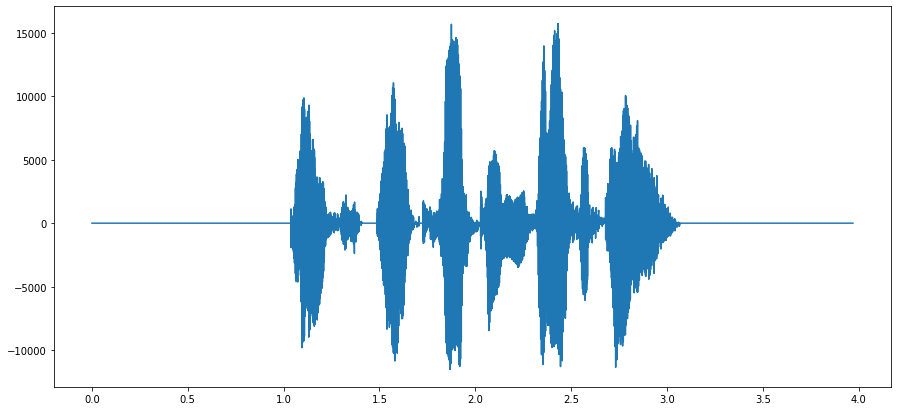

In [162]:
mid = 0
for k in range(data.shape[0]):
    mid += abs(data[k])
mid = mid / data.shape[0]
alpha = 0.19
Th = alpha * mid
k = 25

y = np.zeros(data.shape[0])
is_signal = False
count_of_signal = 0
count_without_signal = 0
for i in range(data.shape[0]):
    if is_signal:
        y[i] = data[i]
    if abs(data[i]) >= Th:
        count_of_signal += 1
        count_without_signal = 0
        if count_of_signal == k:
            is_signal = True
            y[i] = data[i]
    else:
        count_without_signal += 1
        count_of_signal = 0
        if count_without_signal == k:
            is_signal = False
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
ax.plot(time, y)
IPython.display.Audio(y, rate=samplerate)

## 4. Эффект "Эхо"
Ревербератор реализован, как набор линий задержки. Число линий задержки $N_L>=8$
Каждая линия задержки имеет свой весовой коэффициент (задается пользователем):
$\alpha1>\alpha2>...>\alpha_{N_L}$\
Перед добавлением к исходному сигналу, выход ревербератора фильтруется
ФНЧ-фильтром первого порядка.\
Желаемое соотношение между ”сухим”и обработанным сигналом задается
коэффициентом применимости $\gamma$.\
Ревербератор может работать в двух режимах: ручной и с использованием готовой
конфигурации (preset). Для ручного режима регулируется пользователем задается
максимальная задержка D_1, а величины остальных определяются автоматически через
нее:\
$D_i = D_12\frac{1-i}{N_L}, i=2,...,N_L$
Для готовой конфигурации пользователь вручную задает последовательность\
$D_1>D_2>...>D_{N_L}$\
Были взяты следующие константы\
$N_L$ = 8\
$\gamma$ = 0.7

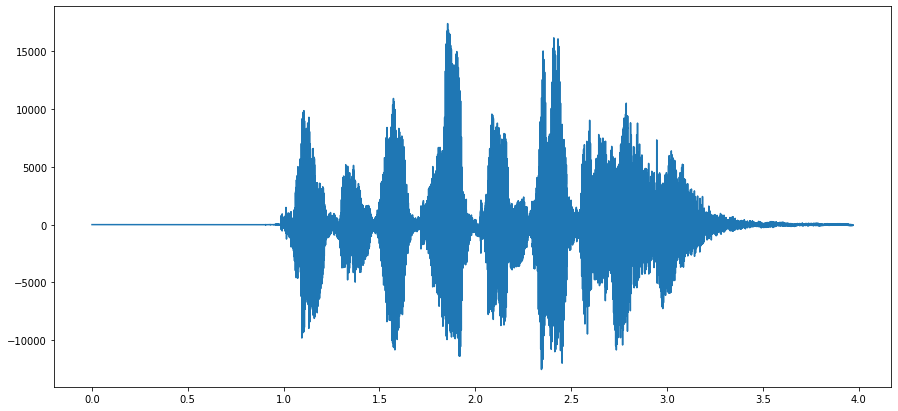

In [165]:
NL = 8
d = [int(80/335 * samplerate)]
gamma = 0.7

for i in range(0, NL - 1):
    d.append(int(d[-1]*2**((1-i)/NL)))

a = [0.99*(1/i**3) for i in range(1, NL + 1)]

new_arr = np.zeros(data.size)

temp = 0
for i in range(0, len(d)):
    temp += d[i]
    for j in range(0, data.shape[0] - temp):
        new_arr[j + temp] += data[j] * a[i]

new_arr = lowpass(new_arr, 1)

for i in range(0,data.size):
    new_arr[i] *= gamma
    new_arr[i] += data[i]
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
ax.plot(time, new_arr)
    
IPython.display.Audio(new_arr, rate=samplerate)

## Эффект "Distortion"(классический вариант)
Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i) i = 0,1,...,N − 1$. Пользователь задает порог — $Th$ и максимальное значение сигнала $Max>Th$. Тогда\
$Y(i) = 
 \begin{cases} x(i), |x(i)|\leq Th, \\ Max * sign(x(i)), |x(i)|>Th
 \end{cases}
$

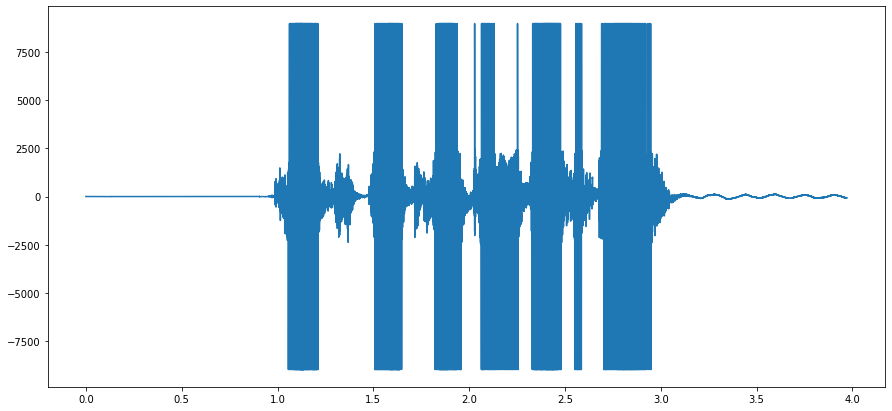

In [153]:
max = 9000

new_arr =[]

def sign(n):
    if n >= 0:
        return 1
    return -1

for i in data:
    if abs(i) <= Th:
        new_arr.append(i)
    else:
        new_arr.append(max * sign(i))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
ax.plot(time, new_arr)

IPython.display.Audio(new_arr, rate=samplerate)

## Вывод
В ходе данной лабораторной рботы были получины навыки работы с Jupyter Notebook, а также были изучены возможности библиотек python для решения задач цифровой обработки сигналов